**Цель проекта**

Нужно построить модель для определения стоимости автомобиля.


Критерии, которые важны заказчику:

- качество предсказания;

- время обучения модели;

- время предсказания модели.

**План исследования**

1) Загрузить данные.

2) Провести предобработку данных.

3) Провести исследовательский анализ данных.

4) Протестировать различные модели.

5) Подобрать оптимальные параметры для моделей.

6) Выбрать лучшую модель и проверить ее на тестовых данных.

7) Сделать вывод о результатах.

## Импорт библиотек и загрузка данных

In [ ]:
!pip install optuna
!pip install shap
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

sns.set()

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Car Price Prediction/autos.csv")

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Признаки**

- **DateCrawled** — дата скачивания анкеты из базы

- **VehicleType** — тип автомобильного кузова

- **RegistrationYear** — год регистрации автомобиля

- **Gearbox** — тип коробки передач

- **Power** — мощность (л. с.)

- **Model** — модель автомобиля

- **Kilometer** — пробег (км)

- **RegistrationMonth** — месяц регистрации автомобиля

- **FuelType** — тип топлива

- **Brand** — марка автомобиля

- **Repaired** — была машина в ремонте или нет

- **DateCreated** — дата создания анкеты

- **NumberOfPictures** — количество фотографий автомобиля

- **PostalCode** — почтовый индекс владельца анкеты (пользователя)

- **LastSeen** — дата последней активности пользователя

**Целевой признак**

- **Price** — цена (евро)


## Предобработка и EDA

Названия признаков даны в стиле CamelCase, приведем его к snake_case.

In [ ]:
def to_snake_case(string):
  converted = string[0].lower()
  for sym in string[1:]:
    if sym.islower():
      converted = converted + sym
    else:
      converted = converted + "_" + sym.lower()

  return converted

In [ ]:
converted_columns = {}
for col in data.columns:
  converted_columns[col] = to_snake_case(col)

converted_columns

{'DateCrawled': 'date_crawled',
 'Price': 'price',
 'VehicleType': 'vehicle_type',
 'RegistrationYear': 'registration_year',
 'Gearbox': 'gearbox',
 'Power': 'power',
 'Model': 'model',
 'Kilometer': 'kilometer',
 'RegistrationMonth': 'registration_month',
 'FuelType': 'fuel_type',
 'Brand': 'brand',
 'Repaired': 'repaired',
 'DateCreated': 'date_created',
 'NumberOfPictures': 'number_of_pictures',
 'PostalCode': 'postal_code',
 'LastSeen': 'last_seen'}

In [ ]:
data = data.rename(columns=converted_columns)

In [ ]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [ ]:
data['number_of_pictures'].value_counts()

0    354369
Name: number_of_pictures, dtype: int64

В каждой анкете фотографии автомобиля отсутствуют. Это делает фичу бесполезной, удалим ее.

In [ ]:
data = data.drop(columns=['number_of_pictures'], axis=1)

Удалим дубликаты

In [ ]:
data.duplicated().sum()

4

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
data['date_crawled'].isna().sum()

0

Пропусков у столбца нет. Приведем его к типу datetime.

In [ ]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'])

In [ ]:
data['vehicle_type'].isna().sum()

37490

В столбце есть много пропусков, удалять их нельзя. Но и заполнить модой кажется не лучшей идеей, это изменит распределение. Заполним пропуски значением unknown.

In [ ]:
data['vehicle_type'] = data['vehicle_type'].fillna("unknown")

In [ ]:
data['registration_year'].isna().sum()

0

Пропуски в столбце отсутствуют.

In [ ]:
np.sort(data['registration_year'].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Столбец содержит странные значения. Не может быть год регистрации выше, чем 2016, так как анкеты были созданы в этом году. Так же кажется странным, что есть автомобили, зарегистрированные в 1970 году и раньше. Посмотрим, сколько объектов с такими значениями.

In [ ]:
data.query('registration_year < 1970 or registration_year > 2016')['registration_year'].count()

15868

Удалим такие строки.

In [ ]:
data = data.query('registration_year > 1969 and registration_year < 2017').reset_index(drop=True)

In [ ]:
data['gearbox'].isna().sum()

17561

Присутствует большое количество пропусков. Удалить их не получится. Таким же образом заполним значением unknown.

In [ ]:
data['gearbox'] = data['gearbox'].fillna("unknown")

In [ ]:
data['gearbox'].value_counts()

manual     256813
auto        64123
unknown     17561
Name: gearbox, dtype: int64

In [ ]:
data['power'].isna().sum()

0

In [ ]:
np.sort(data['power'].unique())

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

Фича содержит аномальноые значнения. Значения мощности автомобиля ниже 40 и выше 1000 кажутся неправдоподобными. Такие значения не могут принести пользы, поэтому их нужно удалить.

In [ ]:
data.query('power < 40 or power > 1000')['power'].count()

37392

In [ ]:
data = data.query('power > 40 and power < 1000').reset_index(drop=True)

In [ ]:
data['model'].isna().sum()

11526

Столбец содержит много пропусков. Заполним их значением unknown.

In [ ]:
data['model'] = data['model'].fillna("unknown")

In [ ]:
data['model'].value_counts()

golf                  25374
other                 20213
3er                   17791
unknown               11526
polo                  10911
                      ...  
serie_2                   4
serie_3                   3
range_rover_evoque        2
601                       2
rangerover                2
Name: model, Length: 250, dtype: int64

Обнаружено много моделей, которые встречаются очень редко.

In [ ]:
data['model'].value_counts()[80:].sum()

37140

Лучше такие значения отнести к категории other.

In [ ]:
data.loc[data['model'].isin(data['model'].value_counts()[100:].index), 'model'] = "other"

In [ ]:
data['kilometer'].isna().sum()

0

В столбце нет пропусков.

In [ ]:
data['kilometer'].value_counts()

150000    200981
125000     32095
100000     12849
90000      10324
80000       9027
70000       7767
60000       6749
50000       5584
40000       4448
30000       3851
20000       3225
5000        3016
10000        891
Name: kilometer, dtype: int64

Со значениями тоже все в порядке.

In [ ]:
data['registration_month'].isna().sum()

0

In [ ]:
data['registration_month'].value_counts()

3     30657
6     27927
4     26012
5     25945
7     24032
10    23247
12    21495
11    21290
9     21212
1     20382
8     20016
0     19497
2     19095
Name: registration_month, dtype: int64

В столбце присутствует некорректное значение месяца - 0. Заменим такие значения на unknown и тип столбца изменим на object.

In [ ]:
data['registration_month'] = data['registration_month'].astype('str')

In [ ]:
data.loc[data['registration_month'] == "0", 'registration_month'] = "unknown"

In [ ]:
data['fuel_type'].isna().sum()

16531

В столбце есть пропуски. Заполним их значением unknown.

In [ ]:
data['fuel_type'] = data['fuel_type'].fillna('unknown')

In [ ]:
data['fuel_type'].value_counts()

petrol      189937
gasoline     88760
unknown      16531
lpg           4793
cng            488
hybrid         202
other           57
electric        39
Name: fuel_type, dtype: int64

Отнесем все категории, кроме трех самых часто встречающихся к категории other.

In [ ]:
data.loc[data['fuel_type'].isin(data['fuel_type'].value_counts()[3:].index), 'fuel_type'] = "other"

In [ ]:
data['brand'].isna().sum()

0

In [ ]:
data['brand'].value_counts().count()

40

В столбце нет пропусков. Он содержит 40 значений.

In [ ]:
data['repaired'].isna().sum()

44751

In [ ]:
data['repaired'].value_counts()

no     225927
yes     30129
Name: repaired, dtype: int64

Заполним пропуски значением unknown.

In [ ]:
data['repaired'] = data['repaired'].fillna('unknown')

In [ ]:
data['date_created'].isna().sum()

0

Пропусков нет. Переведем столбец в формат даты.

In [ ]:
data['date_created'] = pd.to_datetime(data['date_created'], format="%Y-%m-%d")

In [ ]:
data['date_created'].dt.year.value_counts()

2016    300783
2015        24
Name: date_created, dtype: int64

Почти все анкеты были созданы в 2016 году.

In [ ]:
data['postal_code'].isna().sum()

0

In [ ]:
data['last_seen'].isna().sum()

0

In [ ]:
data['last_seen'] = pd.to_datetime(data['last_seen'], format="%Y-%m-%d")

В столбцах нет пропусков.

In [ ]:
data['price'].isna().sum()

0

В таргете пропусков нет.

Столбцы date_crawled, date_created, postal code и last_seen для обучения модели не понадобятся. Удалим их.

In [ ]:
data = data.drop(columns=['date_crawled', 'date_created', 'postal_code', 'last_seen'], axis=1)

In [ ]:
data.duplicated().sum()

23752

После удаления некоторых фичей в данных появились дубликаты. Удалим их.

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277055 entries, 0 to 277054
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               277055 non-null  int64 
 1   vehicle_type        277055 non-null  object
 2   registration_year   277055 non-null  int64 
 3   gearbox             277055 non-null  object
 4   power               277055 non-null  int64 
 5   model               277055 non-null  object
 6   kilometer           277055 non-null  int64 
 7   registration_month  277055 non-null  object
 8   fuel_type           277055 non-null  object
 9   brand               277055 non-null  object
 10  repaired            277055 non-null  object
dtypes: int64(4), object(7)
memory usage: 23.3+ MB


Предобработка закончена. Приступим к EDA.

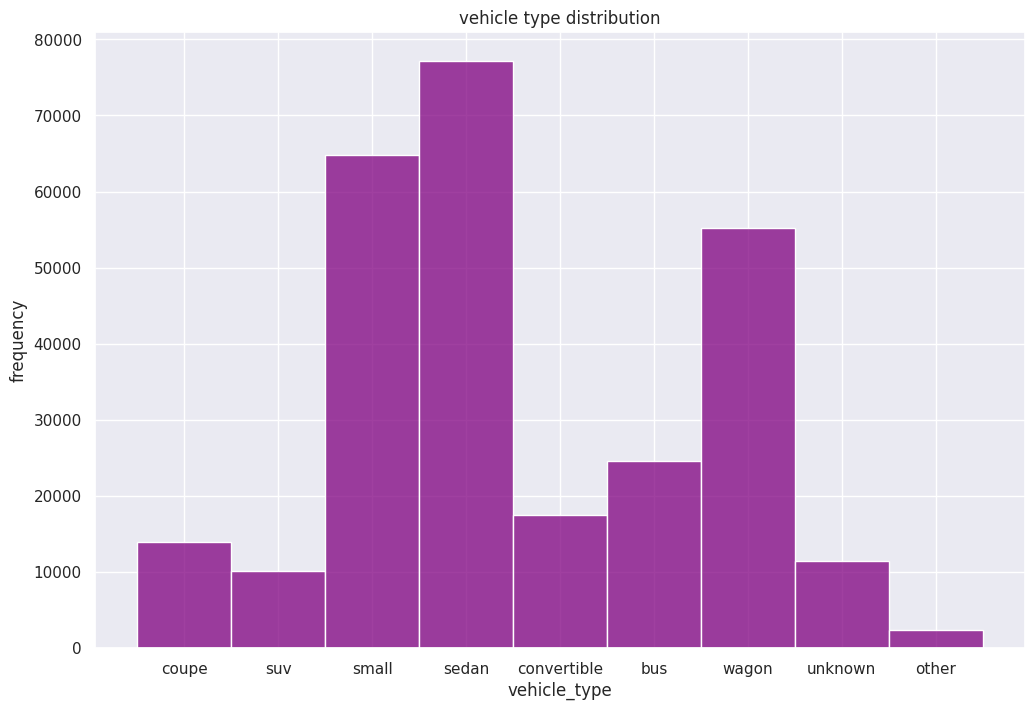

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['vehicle_type'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='vehicle_type')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='vehicle type distribution')
plt.show()

Фича содержит девять категорий.

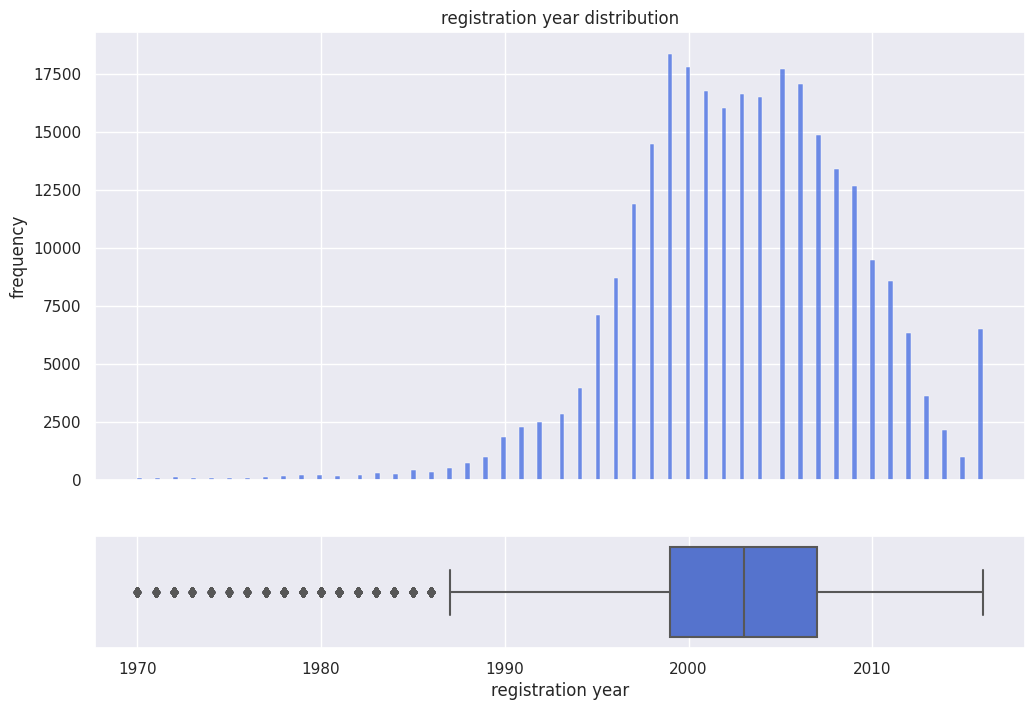

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['registration_year'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['registration_year'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='registration year')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='registration year distribution')
plt.show()

Значения ниже 1985 являются выбросами.

In [ ]:
data.query('registration_year < 1985')['registration_year'].count()

2590

Их немного, избавимся от них.

In [ ]:
data = data.query('registration_year > 1985').reset_index(drop=True)

Признак имеет нормальное распределение.

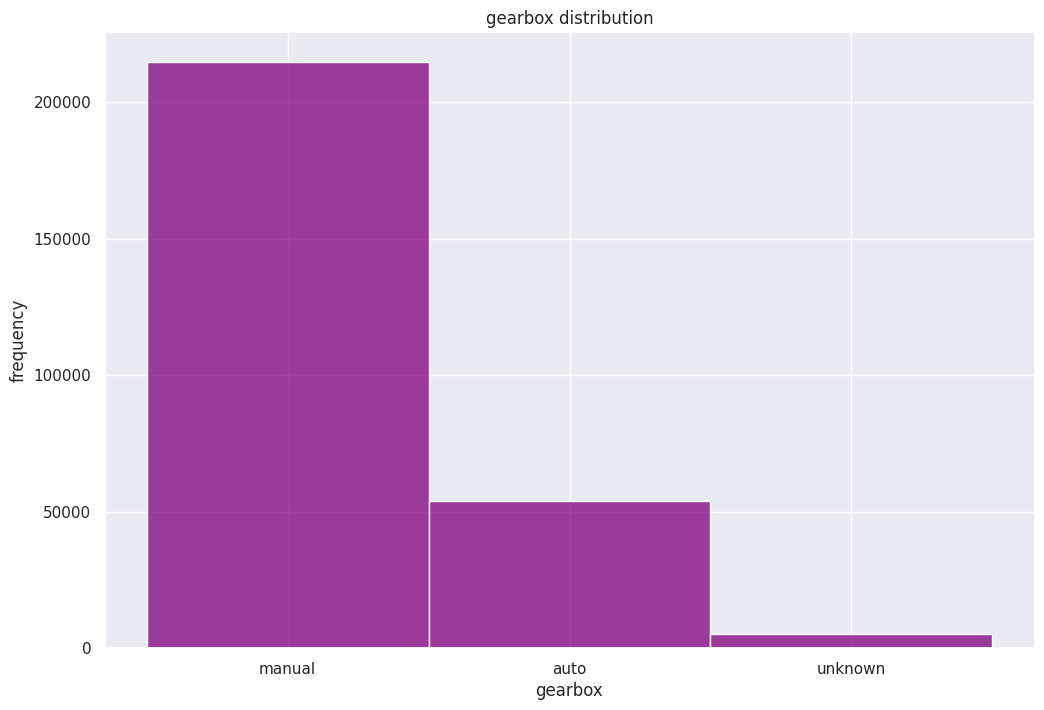

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['gearbox'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='gearbox')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='gearbox distribution')
plt.show()

80% автомобилей на ручной коробке передач.

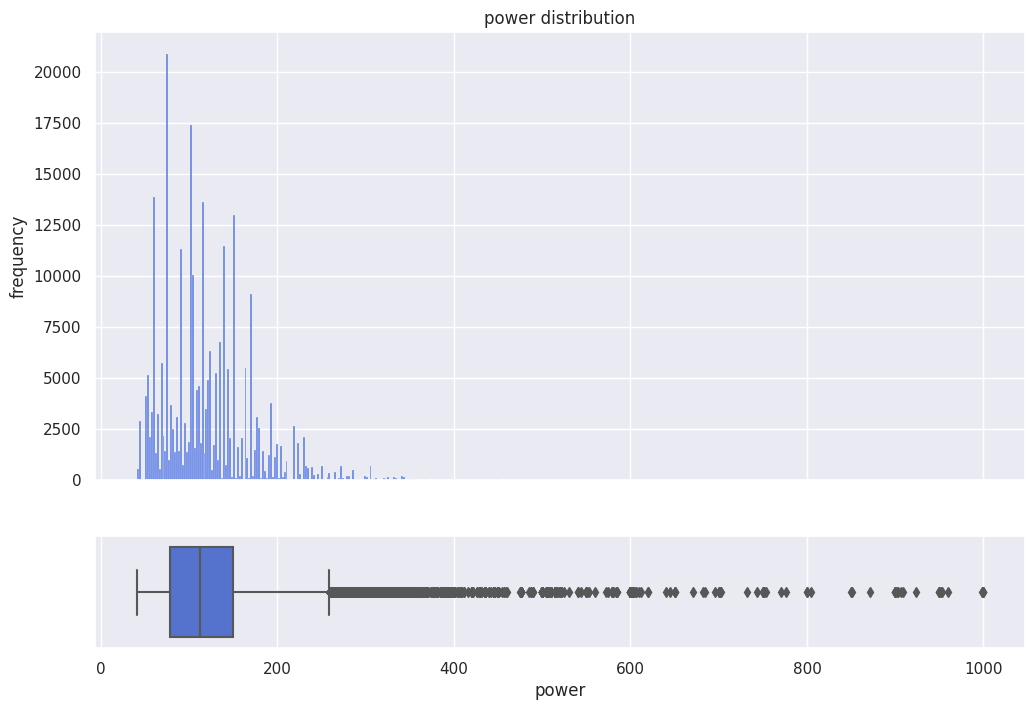

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['power'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['power'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='power')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='power distribution')
plt.show()

В столбце есть выбросы.

In [ ]:
data.query('power > 230')['power'].count()

11407

Выбросов немного, можно их удалить.

In [ ]:
data = data.query('power < 230').reset_index(drop=True)

Распределение у фичи логнормальное.

Выведем гистограмму для 10 самых частых моделей.

In [ ]:
top_10_models = data[data['model'].isin(data['model'].value_counts().sort_values(ascending=False)[:10].index)]

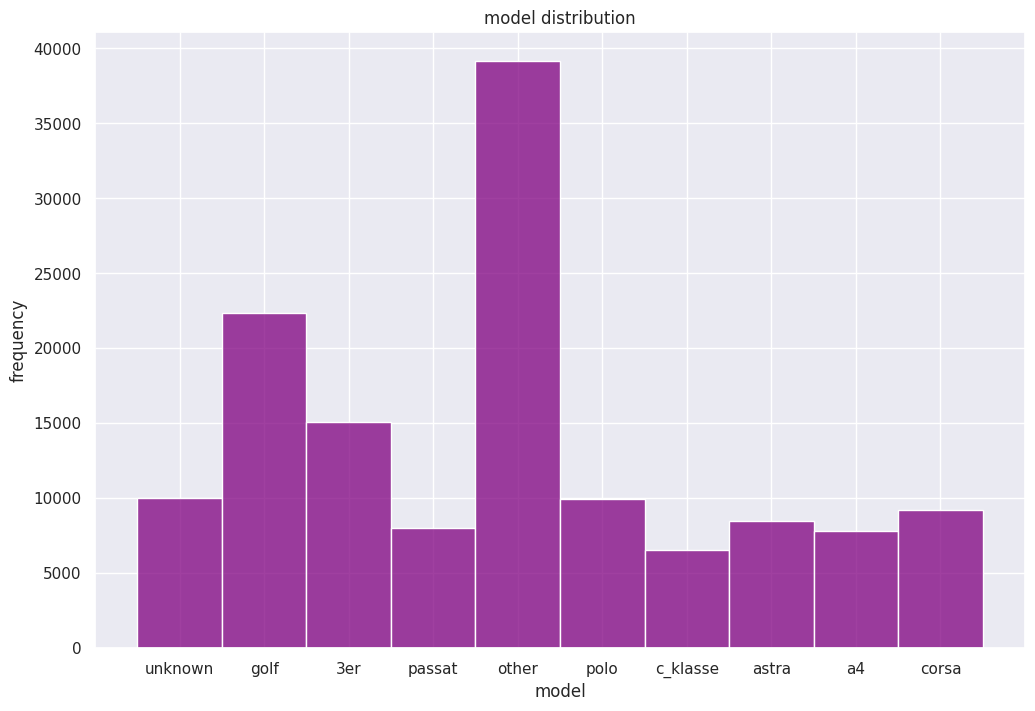

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=top_10_models['model'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='model')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='model distribution')
plt.show()

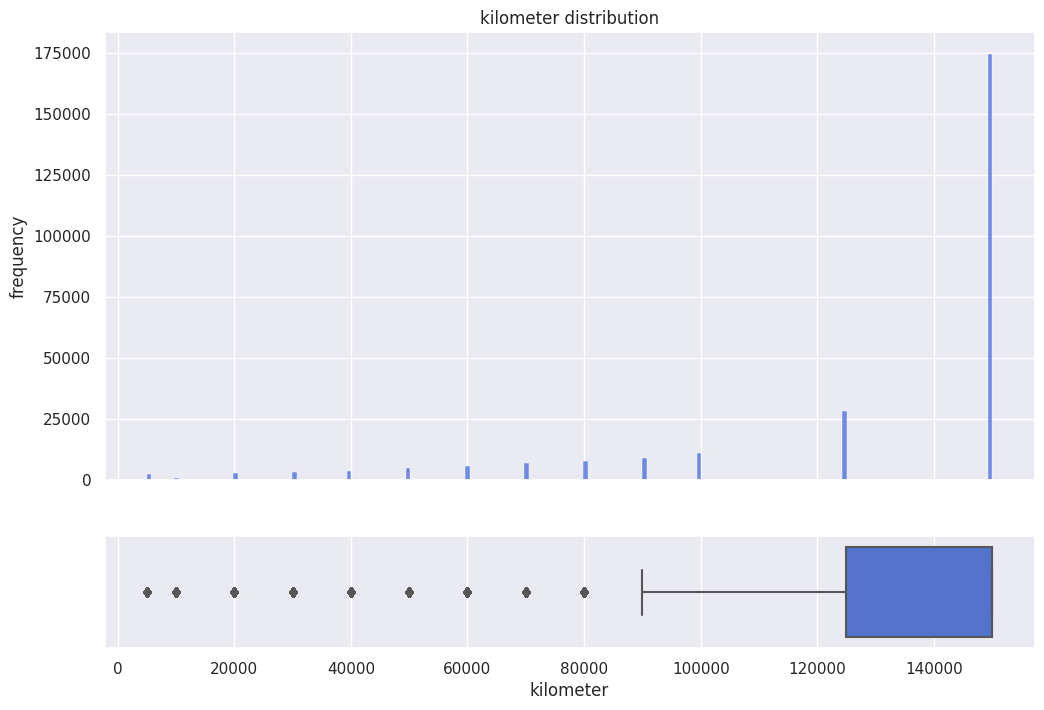

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['kilometer'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['kilometer'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='kilometer')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='kilometer distribution')
plt.show()

Узнаем количество выбросов столбца.

In [ ]:
data.query('kilometer < 90000')['kilometer'].count()

39219

Их слишком большое количество. Не будем их удалять.

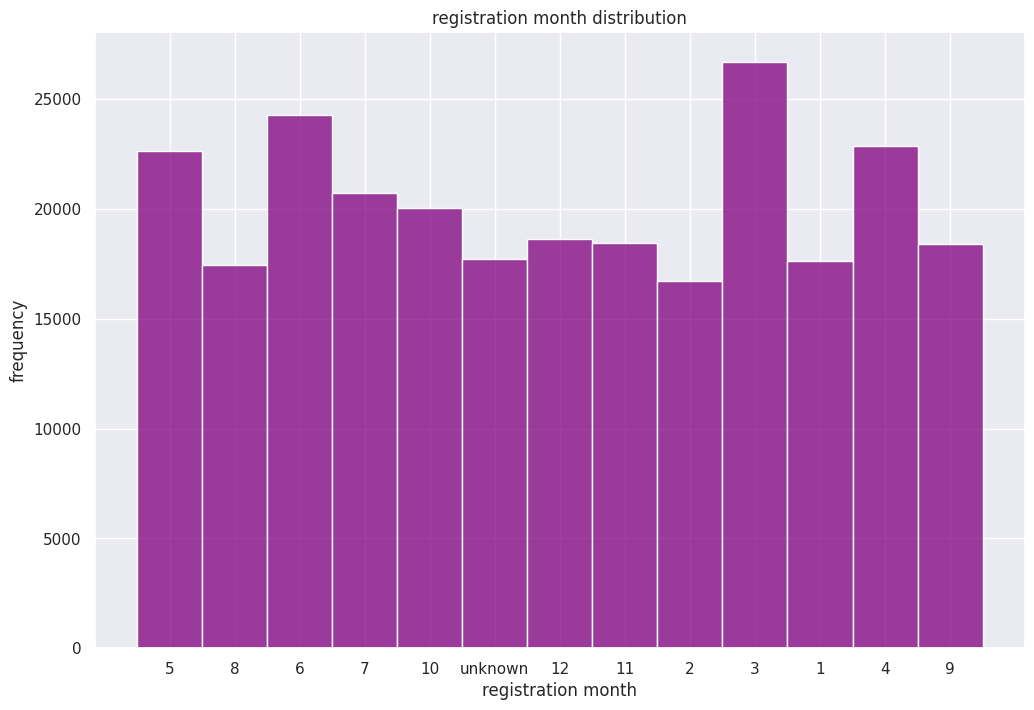

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['registration_month'], ax=ax_hist, color='purple', bins=13)

ax_hist.set(xlabel='registration month')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='registration month distribution')
plt.show()

Больше всего автомобилей было зарегестрировано в марте, июне, апреле и мае. В остальном данные распределены равномерно.

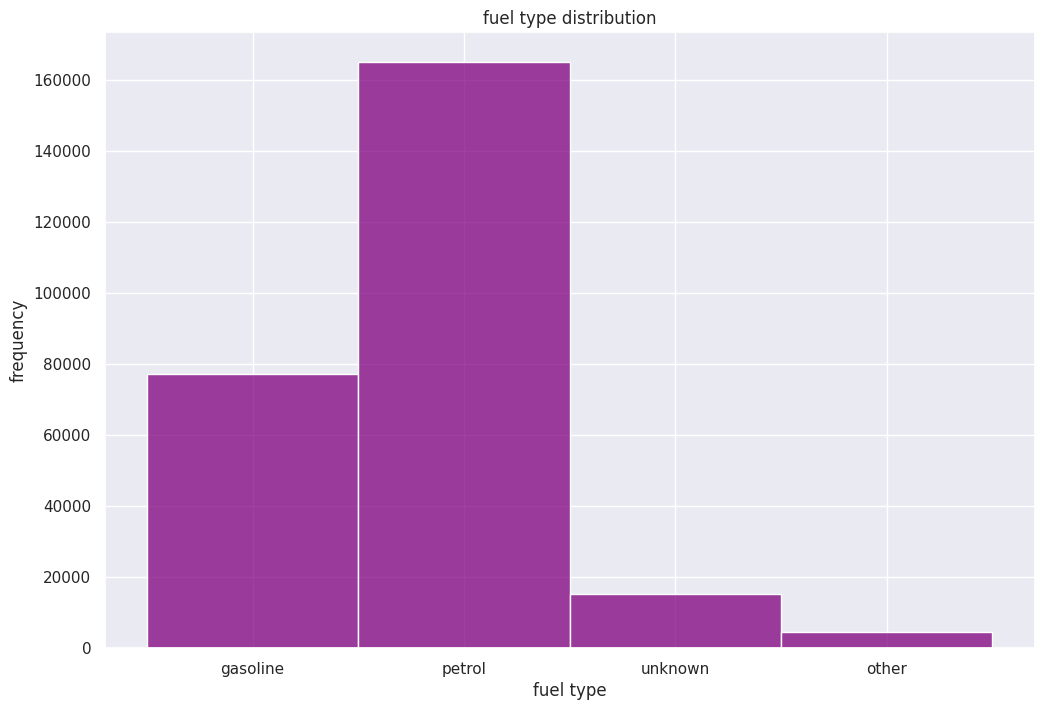

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['fuel_type'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='fuel type')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='fuel type distribution')
plt.show()

Самый частый тип топлива - petrol.

Получим гистограмму 10 самых частых брендов.

In [ ]:
top_10_brands = data.loc[data['brand'].isin(data['brand'].value_counts()[:10].index), 'brand']

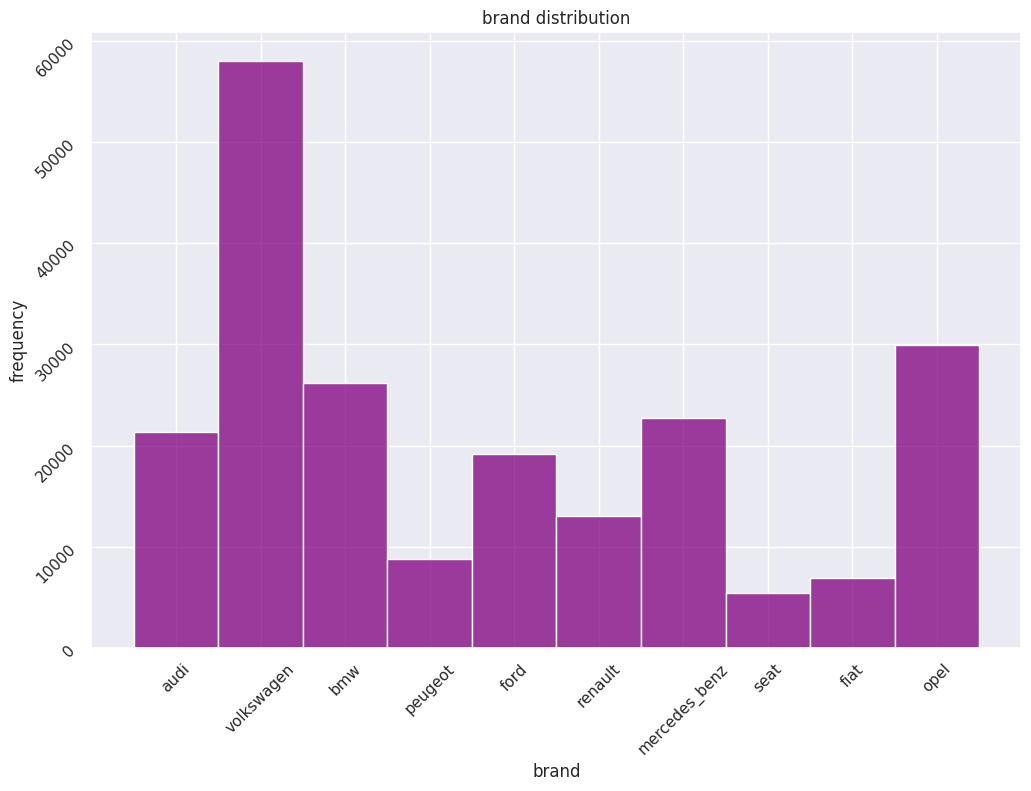

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=top_10_brands, ax=ax_hist, color='purple')

ax_hist.set(xlabel='brand')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='brand distribution')
ax_hist.tick_params(labelrotation=45)
plt.show()

Volkswagen - встречается в анкетах в два раза чаще, чем любая другая марка автомобиля.

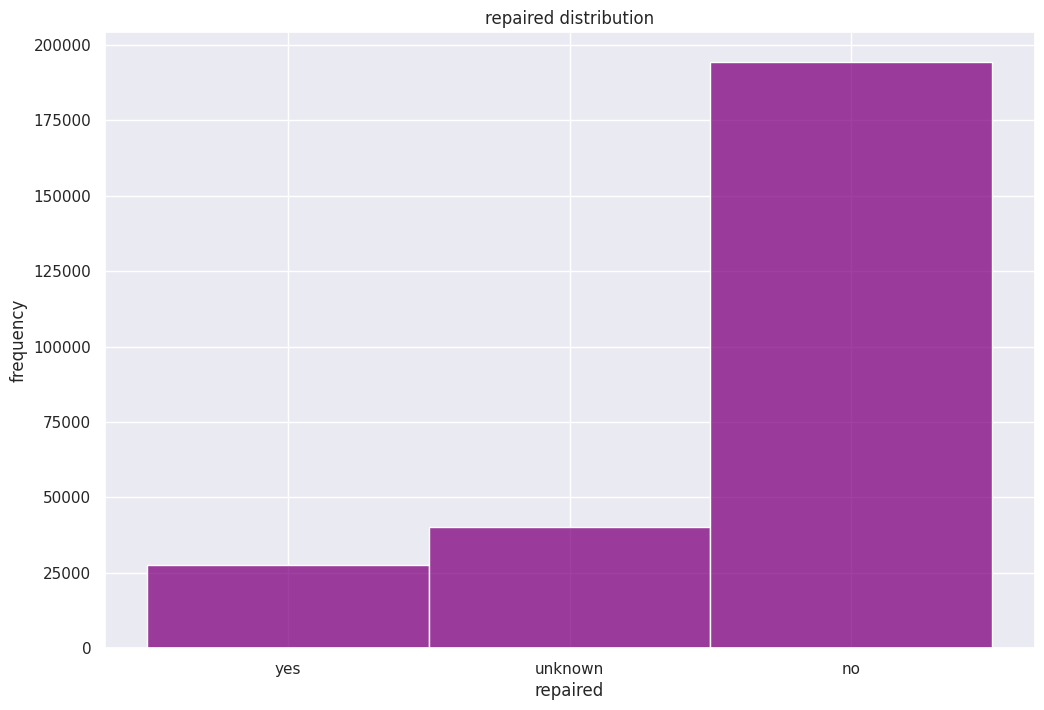

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['repaired'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='repaired')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='repaired distribution')
plt.show()

Большинство машин не ремонтировалось.

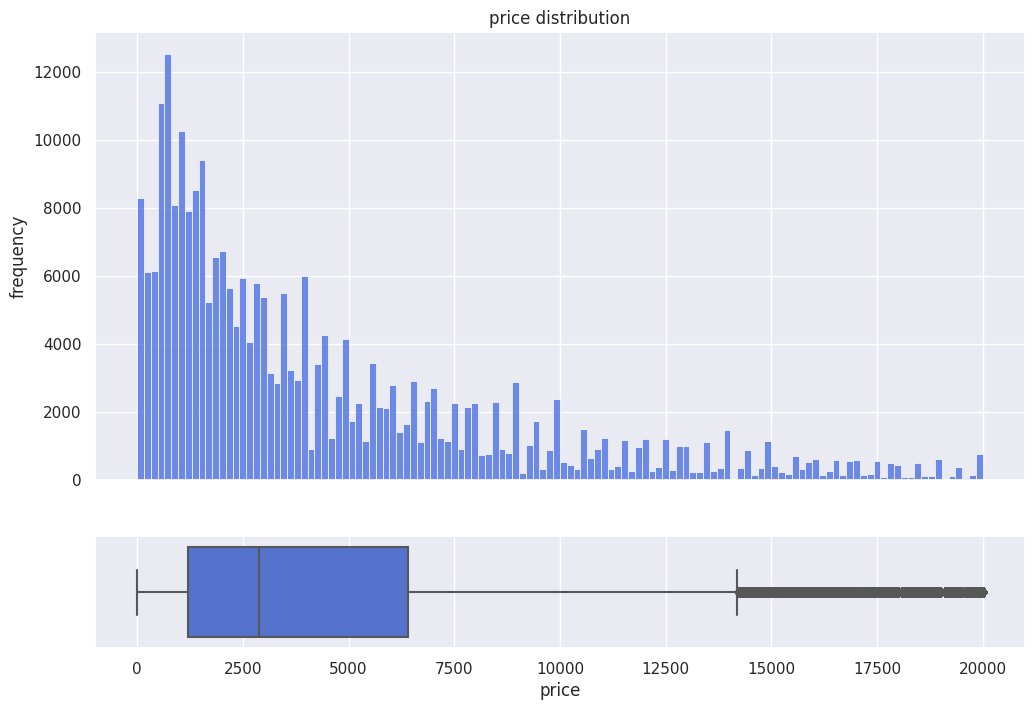

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['price'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['price'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='price')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='price distribution')
plt.show()

В таргете есть много выбросов. Их можно удалить.

In [ ]:
data[data['price'] > 14500]['price'].count()

11999

In [ ]:
data = data.query('price < 14500').reset_index(drop=True)

Таргет имеет экспоненциальное распределение.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249749 entries, 0 to 249748
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               249749 non-null  int64 
 1   vehicle_type        249749 non-null  object
 2   registration_year   249749 non-null  int64 
 3   gearbox             249749 non-null  object
 4   power               249749 non-null  int64 
 5   model               249749 non-null  object
 6   kilometer           249749 non-null  int64 
 7   registration_month  249749 non-null  object
 8   fuel_type           249749 non-null  object
 9   brand               249749 non-null  object
 10  repaired            249749 non-null  object
dtypes: int64(4), object(7)
memory usage: 21.0+ MB


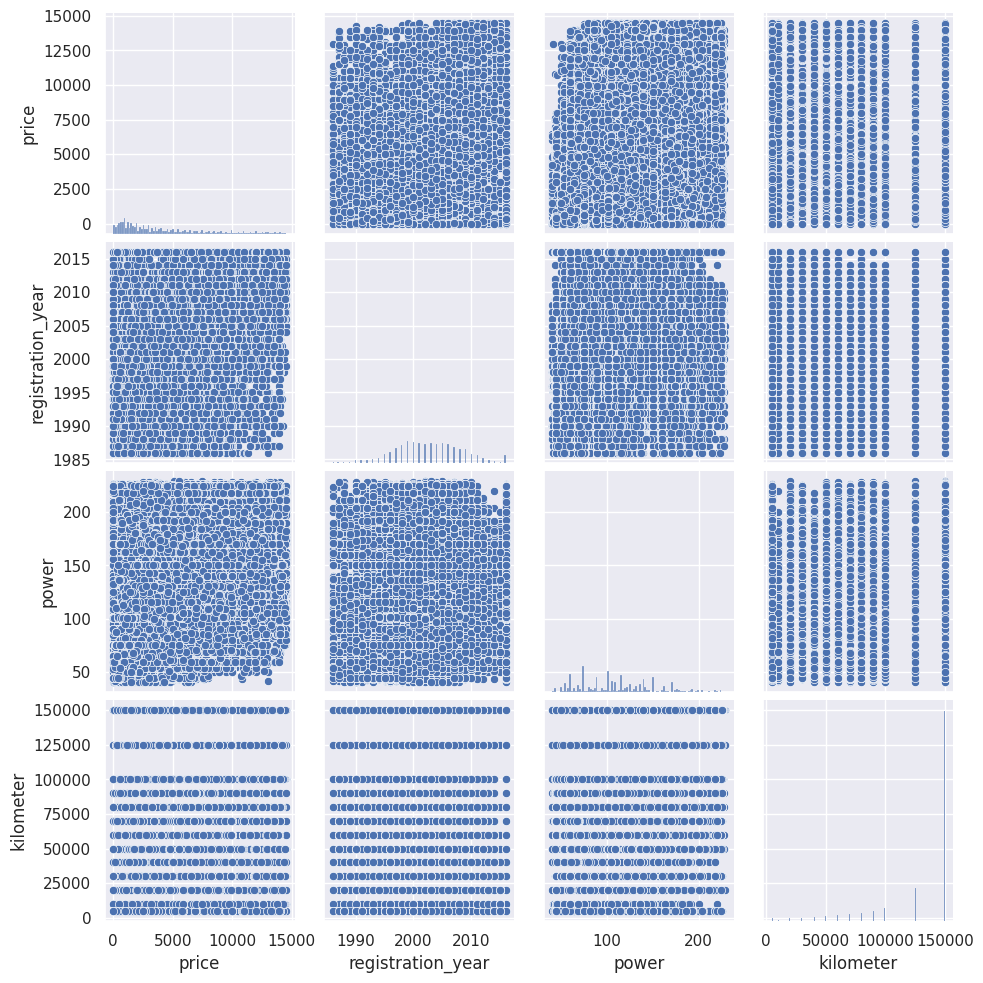

In [ ]:
sns.pairplot(data)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

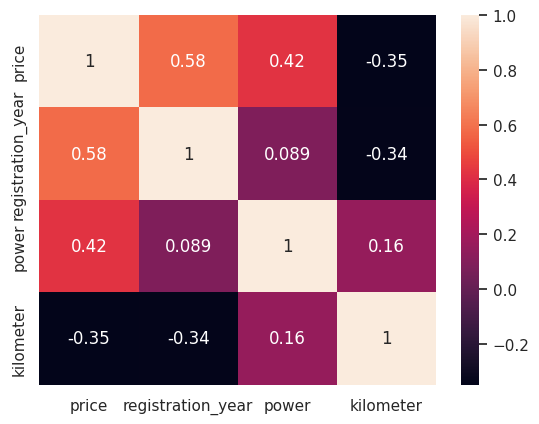

In [ ]:
sns.heatmap(data.corr(), annot=True)

В датасете есть слабая положительная корреляция между ценой и годом регистрации, ценой и мощностью, слабая отрицательная корреляция между ценой и количеством пройденных километров и между пройденными километрами и годом регистрации.

Напишем функцию предобработки тестовых данных.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249749 entries, 0 to 249748
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               249749 non-null  int64 
 1   vehicle_type        249749 non-null  object
 2   registration_year   249749 non-null  int64 
 3   gearbox             249749 non-null  object
 4   power               249749 non-null  int64 
 5   model               249749 non-null  object
 6   kilometer           249749 non-null  int64 
 7   registration_month  249749 non-null  object
 8   fuel_type           249749 non-null  object
 9   brand               249749 non-null  object
 10  repaired            249749 non-null  object
dtypes: int64(4), object(7)
memory usage: 21.0+ MB


## Обучение моделей

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 8:1:1.

In [ ]:
x = data.drop(columns=['price'], axis=1)
y = data['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=987)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, train_size=0.5, random_state=987)

In [ ]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((199799, 10), (199799,), (24975, 10), (24975,), (24975, 10), (24975,))

In [ ]:
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

Сперва обучим линейную регрессию.

Для линейных моделей необходимо использовать стандартизацию и one hot encoding.

In [ ]:
cat_features = ['vehicle_type','gearbox', 'model', 'registration_month', 'fuel_type', 'brand', 'repaired']
num_features = ['registration_year', 'power', 'kilometer']

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [ ]:
x_train_ohe = pd.DataFrame(ohe.fit_transform(x_train[cat_features]), columns=ohe.get_feature_names_out())
x_train_ohe[num_features] = x_train[num_features]

In [ ]:
x_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199799 entries, 0 to 199798
Columns: 168 entries, vehicle_type_convertible to kilometer
dtypes: float64(165), int64(3)
memory usage: 256.1 MB


In [ ]:
st_scaler = StandardScaler()

In [ ]:
x_train_ohe_st = pd.DataFrame(st_scaler.fit_transform(x_train_ohe), columns=x_train_ohe.columns)

In [ ]:
lin_reg = LinearRegression()

In [ ]:
%%time

abs(cross_val_score(lin_reg, x_train_ohe_st, y_train, scoring='neg_root_mean_squared_error', cv=5)).mean()

CPU times: user 22.7 s, sys: 5.63 s, total: 28.3 s
Wall time: 37.6 s


1913.9975487914453

RMSE модели линейной регрессии на обучающих данных равняется 1913.

Проверим модель на валидационной выборке.

In [ ]:
x_valid_ohe = pd.DataFrame(ohe.transform(x_valid[cat_features]), columns=ohe.get_feature_names_out())
x_valid_ohe[num_features] = x_valid[num_features]

x_valid_ohe_st = pd.DataFrame(st_scaler.transform(x_valid_ohe), columns=x_valid_ohe.columns)

In [ ]:
lin_reg.fit(x_train_ohe_st, y_train)

mean_squared_error(y_valid, lin_reg.predict(x_valid_ohe_st)) ** 0.5

1889.101979856519

Модель работает так же хорошо и на валидационной выборке.

Обучим модель градиентного бустинга CatBoost.

Применим порядковое кодирование.

In [ ]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
x_train_ord = pd.DataFrame(ord_enc.fit_transform(x_train[cat_features]), columns=cat_features)
x_train_ord[num_features] = x_train[num_features]

In [ ]:
x_train_ord.head()

,vehicle_type,gearbox,model,registration_month,fuel_type,brand,repaired,registration_year,power,kilometer
0,4.0,1.0,48.0,11.0,0.0,38.0,0.0,2006,105,150000
1,5.0,1.0,91.0,6.0,3.0,24.0,0.0,1996,60,150000
2,4.0,0.0,28.0,0.0,2.0,20.0,0.0,2011,156,80000
3,7.0,1.0,67.0,5.0,2.0,9.0,2.0,2005,103,150000
4,5.0,1.0,51.0,12.0,2.0,30.0,1.0,2012,69,70000


In [ ]:
x_valid_ord = pd.DataFrame(ord_enc.transform(x_valid[cat_features]), columns=cat_features)
x_valid_ord[num_features] = x_valid[num_features]

In [ ]:
cat_boost = CatBoostRegressor(verbose=250, random_state=987)

In [ ]:
%%time

abs(cross_val_score(cat_boost, x_train_ord, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

Learning rate set to 0.091277
0:	learn: 3248.3968778	total: 88.7ms	remaining: 1m 28s
250:	learn: 1369.3217338	total: 8.34s	remaining: 24.9s
500:	learn: 1316.6370562	total: 15.5s	remaining: 15.5s
750:	learn: 1287.0420771	total: 23s	remaining: 7.61s
999:	learn: 1264.7696567	total: 28.1s	remaining: 0us
Learning rate set to 0.091277
0:	learn: 3244.1494164	total: 27.9ms	remaining: 27.8s
250:	learn: 1367.5128370	total: 9.68s	remaining: 28.9s
500:	learn: 1316.9501233	total: 15s	remaining: 15s
750:	learn: 1285.9138600	total: 21.8s	remaining: 7.22s
999:	learn: 1264.3447150	total: 29.4s	remaining: 0us
Learning rate set to 0.091277
0:	learn: 3247.4029404	total: 21.2ms	remaining: 21.1s
250:	learn: 1366.2069267	total: 5.16s	remaining: 15.4s
500:	learn: 1313.0686405	total: 15.7s	remaining: 15.7s
750:	learn: 1281.8484570	total: 22.2s	remaining: 7.35s
999:	learn: 1260.0200612	total: 29.6s	remaining: 0us
Learning rate set to 0.091277
0:	learn: 3245.3153772	total: 50.2ms	remaining: 50.2s
250:	learn: 136

1321.3578335004158

Модель градиентного бустинга получила намного лучший скор - 1320.

In [ ]:
cat_boost.fit(x_train_ord, y_train, eval_set=(x_valid_ord, y_valid))

Learning rate set to 0.116974
0:	learn: 3196.1636246	test: 3187.9790506	best: 3187.9790506 (0)	total: 28.1ms	remaining: 28s
250:	learn: 1349.4154430	test: 1352.3296739	best: 1352.3296739 (250)	total: 6.82s	remaining: 20.3s
500:	learn: 1299.2766264	test: 1319.4056864	best: 1319.4056864 (500)	total: 17.8s	remaining: 17.7s
750:	learn: 1271.0406176	test: 1303.3817505	best: 1303.3817505 (750)	total: 24.3s	remaining: 8.06s
999:	learn: 1250.9496072	test: 1294.3824813	best: 1294.3473239 (996)	total: 34.8s	remaining: 0us

bestTest = 1294.347324
bestIteration = 996

Shrink model to first 997 iterations.


На валидационной выборке результат не отличается - 1294.

Оптимизируем параметры для модели с помощью optuna.

In [ ]:
def objective(trial):
  params = {"learning_rate": trial.suggest_float("learning_rate", 0.05, 0.35),
             'max_depth': trial.suggest_int('max_depth', 3, 15),
             'n_estimators': trial.suggest_int('n_estimators', 100, 500)
            }
  model = CatBoostRegressor(**params, verbose=250, random_state=987)
  cross_val = abs(cross_val_score(model, x_train_ord, y_train, cv=3, scoring='neg_root_mean_squared_error')).mean()
  return cross_val

In [ ]:
sampler = optuna.samplers.TPESampler(seed=987)
study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10)

[I 2023-11-20 04:45:32,774] A new study created in memory with name: no-name-61654613-48ee-4e7d-9a0f-d19b5ab35a77


0:	learn: 3052.4348672	total: 25.2ms	remaining: 11.4s
250:	learn: 1258.2099051	total: 5.64s	remaining: 4.52s
451:	learn: 1196.9185141	total: 11.1s	remaining: 0us
0:	learn: 3052.0200222	total: 68ms	remaining: 30.7s
250:	learn: 1246.4469065	total: 8.77s	remaining: 7.03s
451:	learn: 1186.5384197	total: 13.3s	remaining: 0us
0:	learn: 3056.8638560	total: 22.2ms	remaining: 10s
250:	learn: 1246.7180574	total: 9.62s	remaining: 7.7s
451:	learn: 1188.1193512	total: 14.2s	remaining: 0us
0:	learn: 2985.6019456	total: 174ms	remaining: 1m 21s
250:	learn: 965.0719576	total: 43s	remaining: 37.2s
467:	learn: 848.7393757	total: 1m 21s	remaining: 0us
0:	learn: 2985.2225492	total: 165ms	remaining: 1m 16s
250:	learn: 960.6632600	total: 42.6s	remaining: 36.9s
467:	learn: 842.7741247	total: 1m 19s	remaining: 0us
0:	learn: 2989.8420093	total: 177ms	remaining: 1m 22s
250:	learn: 962.0915217	total: 43.2s	remaining: 37.4s
467:	learn: 841.5807908	total: 1m 18s	remaining: 0us
0:	learn: 2669.6669786	total: 267ms	re

In [ ]:
print('best params:', study.best_params)

best params: {'learning_rate': 0.3236618085845806, 'max_depth': 15, 'n_estimators': 112}


In [ ]:
best_model = CatBoostRegressor(**study.best_params, verbose=250, random_state=987)

In [ ]:
best_model.fit(x_train_ord, y_train, eval_set=(x_valid_ord, y_valid))

0:	learn: 2663.9002686	test: 2660.2611153	best: 2660.2611153 (0)	total: 303ms	remaining: 33.7s
111:	learn: 1010.2628587	test: 1302.3282328	best: 1301.9617438 (86)	total: 39.5s	remaining: 0us

bestTest = 1301.961744
bestIteration = 86

Shrink model to first 87 iterations.


Подбор параметров не дал результатов.

## Тестирование

In [ ]:
x_test_ord = pd.DataFrame(ord_enc.transform(x_test[cat_features]), columns=cat_features)
x_test_ord[num_features] = x_test[num_features]

In [ ]:
x_train_and_valid = pd.concat([x_train_ord, x_valid_ord])
y_train_and_valid = pd.concat([y_train, y_valid])

In [ ]:
best_model.fit(x_train_and_valid, y_train_and_valid)

0:	learn: 2659.9278895	total: 498ms	remaining: 55.2s
111:	learn: 1030.4623081	total: 42.3s	remaining: 0us


In [ ]:
mean_squared_error(y_test, best_model.predict(x_test_ord)) ** 0.5

1297.615517640645

На тестовой выборке модель показала такой же хороший скор. Это говорит о том, что модель не переобучилась и не недообучилась.

**Вывод**

**В ходе выполнения проекта были загружены, предобработаны и проанализированы данные параметров автомобилей на продажу. Были построены модели машинного обучения. Лучшей моделью оказалась CatBoost, которая при тестировании на тестовой выборке показала метрику RMSE = 1297.**